In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
w,h=10,10

In [3]:
def delete_index(T, index):
    return torch.cat([T[:i], T[i+1:]])

In [4]:
def standardize_state(state):
    state = np.copy(state)
    state[0] = (state[0] - ((w-1)/2)) / ((w-1)/2)
    state[1] = (state[1] - ((h-1)/2)) / ((h-1)/2)
    return state
standardize_state([4., 9.]), standardize_state([0., 5.]), standardize_state([4.5, 4.5])

(array([-0.11111111,  1.        ]),
 array([-1.        ,  0.11111111]),
 array([0., 0.]))

In [5]:
def readable_state(state):
    state = np.copy(state)
    state[0] = state[0] * ((w-1)/2) + ((w-1)/2)
    state[1] = state[1] * ((h-1)/2) + ((h-1)/2)
    return state
readable_state(standardize_state([4., 9.])), \
readable_state(standardize_state([0., 5.])), \
readable_state(standardize_state([4.5, 4.5]))

(array([4., 9.]), array([0., 5.]), array([4.5, 4.5]))

In [6]:
class MomentumObject:
    def __init__(self, w, h):
        self.w, self.h = w,h
        self.position = np.array([w/2, h/2])
        self.blank_state = np.zeros((w,h))
        self.speed = np.random.randint(-2, 2, size=2)
    def _jump_bound(self, position):
        if position[0] >= self.w:
            position[0] = position[0] - self.w
        elif position[0] < 0:
            position[0] = self.w + position[0]
        if position[1] >= self.h:
            position[1] = position[1] - self.w
        elif position[1] < 0:
            position[1] = self.h + position[1]
    def get_state_action(self):
        return np.concatenate((self.position, self.speed))
    def step(self):
        self.position += self.speed
        self._jump_bound(self.position)
        self.speed = np.random.randint(-2, 2, size=2)
    def render(self, predict_position=None):
        state = self.blank_state.copy()
        position = np.round(self.position).astype(int)
        state[position[0], position[1]] = 1
        if predict_position is not None:
            pred_x = np.round(predict_position[0]*(self.w-1)).astype(int)
            pred_y = np.round(predict_position[1]*(self.h-1)).astype(int)
            state[pred_x, pred_y] = 0.2
        return state
momentum_object = MomentumObject(w, h)
momentum_object.render()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
num_buffer = 128
dimension_state = 2
num_state = momentum_object.position.shape[0] + momentum_object.speed.shape[0]
states_actions = torch.zeros((num_buffer, num_state))

def update_state_buffer(states_actions, remove_index=None):
    new_state_action = torch.unsqueeze(torch.tensor(momentum_object.get_state_action()), 0)
    if remove_index is None:
        states_actions = states_actions[:-1]
    else:
        states_actions = delete_index(states_actions, remove_index)
    return torch.cat((new_state_action, states_actions))
for i in range(num_buffer):
    momentum_object.step()
    states_actions=update_state_buffer(states_actions)
states_actions

tensor([[ 4.,  4., -2.,  0.],
        [ 4.,  4.,  0.,  0.],
        [ 6.,  4., -2.,  0.],
        [ 7.,  6., -1., -2.],
        [ 9.,  7., -2., -1.],
        [ 9.,  6.,  0.,  1.],
        [ 0.,  6., -1.,  0.],
        [ 9.,  8.,  1., -2.],
        [ 0.,  7., -1.,  1.],
        [ 0.,  6.,  0.,  1.],
        [ 9.,  5.,  1.,  1.],
        [ 0.,  6., -1., -1.],
        [ 2.,  8., -2., -2.],
        [ 1.,  0.,  1., -2.],
        [ 2.,  2., -1., -2.],
        [ 2.,  4.,  0., -2.],
        [ 2.,  6.,  0., -2.],
        [ 4.,  7., -2., -1.],
        [ 4.,  6.,  0.,  1.],
        [ 5.,  7., -1., -1.],
        [ 6.,  6., -1.,  1.],
        [ 8.,  6., -2.,  0.],
        [ 7.,  5.,  1.,  1.],
        [ 9.,  7., -2., -2.],
        [ 1.,  8., -2., -1.],
        [ 3.,  8., -2.,  0.],
        [ 4.,  8., -1.,  0.],
        [ 5.,  0., -1., -2.],
        [ 4.,  1.,  1., -1.],
        [ 6.,  0., -2.,  1.],
        [ 8.,  1., -2., -1.],
        [ 7.,  2.,  1., -1.],
        [ 9.,  2., -2.,  0.],
        [ 

In [9]:
def train(i, encoder, states_actions, optimizer_encoder):
    encoder.train()
    states_actions = states_actions.to(device)
    optimizer_encoder.zero_grad()
    
    current_state = torch.clone(states_actions[1:]).to(device).to(device)
    next_state = torch.clone(states_actions[:-1, :2]).to(device)
    
    current_state[:, 0] = current_state[:, 0] - ( (w-1)/2)
    current_state[:, 1] = current_state[:, 1] - ((h-1)/2)
    next_state[:, 0] = next_state[:, 0]/(w-1)
    next_state[:, 1] = next_state[:, 1]/(h-1)
    
    state_prediction = encoder(current_state)
    loss = mse_loss(state_prediction, next_state)
    print("loss[", i,"]:", loss.mean())
    
    loss.mean().backward()
    optimizer_encoder.step()
    
    return torch.argmin(loss.mean(axis=1)).type(torch.int)
    
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = nn.Sequential(
                nn.Linear(4,16),
                nn.ReLU(),
                nn.Linear(16,32),
                nn.ReLU(),
                nn.Linear(32,8),
                nn.ReLU(),
                nn.Linear(8,2),
                nn.Sigmoid()).to(device).to(torch.float64)

optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001)
mse_loss = nn.MSELoss(reduction='none')

lowest_loss_index = None
for i in range(1):
    momentum_object.step()
    states_actions=update_state_buffer(states_actions, lowest_loss_index)
    lowest_loss_index = train(i, encoder, states_actions, optimizer_encoder)


loss[ 0 ]: tensor(0.1018, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/animation.py", line 1081, in _start
    self._init_draw()
  File "/usr/lib/python3/dist-packages/matplotlib/animation.py", line 1792, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
TypeError: 'numpy.ndarray' object is not an iterator


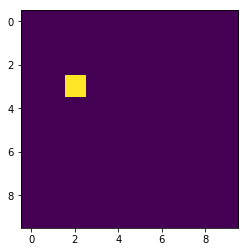

In [11]:
fig = plt.figure()
im = plt.imshow(momentum_object.render(), animated=True)
def init_func():
    return momentum_object.render()
def updatefig(*args):
    position = torch.tensor([momentum_object.get_state_action()]).to(device)
    position[:, 0] = position[:, 0] - ( (w-1)/2)
    position[:, 1] = position[:, 1] - ((h-1)/2)
    
    predict_position = encoder(position).cpu().detach().numpy()[0]
    momentum_object.step()
    im.set_array(momentum_object.render(predict_position))
ani = FuncAnimation(fig, updatefig, init_func, interval=500, blit=True)
# plt.show()

In [ ]:
for i in range(100):
    momentum_object.step()
    position = torch.tensor([momentum_object.get_state_action()]).to(device)
    predict_position = encoder(position).cpu().detach().numpy()[0]
    print(predict_position)
    im.set_array(momentum_object.render(predict_position))